In [1]:
#imports
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import tpot
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (make_scorer, confusion_matrix,
                             silhouette_score, roc_curve,
                             precision_recall_curve, classification_report)
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings('ignore')

In [211]:
# carregando o conjunto de treinamento
df = pd.read_csv('train.csv')

Tamanho e tipos de variáveis no dataset. Há apenas variáveis numéricas:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


Não há valores "missing" no dataset:

In [5]:
print("""Quantidade de colunas com pelo menos um valor
missing no conjunto de treinamento: {}""".format(df.isnull().sum().rename('amt_missing').to_frame().query("amt_missing>0").shape[0]))


Quantidade de colunas com pelo menos um valor missing no conjunto de treinamento: 0


<center> <font size=5> <b> Questão A </b> </font> </center>

In [6]:
target = 'TARGET'

all_vars = list(set(df.columns) - set([target,'ID']))

# separando o dataset rotulado em conjunto de treinamento e teste 
#(80%/20% do dataset original)
X_train, X_test, y_train, y_test = train_test_split(df[all_vars],
                                                    df[target],
                                                    test_size=0.2,
                                                    random_state=42)

# A separação é necessária para validarmos 
# o quão bem o modelo generaliza
# num conjunto de dados nunca visto antes

A target é bastante desbalanceada (apenas 4% das observações são da classe positiva) e isso pode afetar a performance do algorítimo de classificação, ver plot abaixo. Isso tende a favorecer a classificação da classe majoritária, o que fica evidente ao se analisar as métricas de avaliação, como discutiremos mais tarde. Ao se optar por balancear as classes há duas alternativas: o "undersampling" ou o "oversampling". É possível optar por treinar o algorítmo de classificação sem o balanceamento também, sendo que nesse caso a avaliação do modelo deve ser focada na análise das probabilidades e não no output da classificação em si, que poderia ser "misleading". Analisaremos cada uma das alternativas a seguir.

In [7]:
print(y_train.value_counts()/y_train.shape[0])
print(y_test.value_counts()/y_test.shape[0])

0    0.96052
1    0.03948
Name: TARGET, dtype: float64
0    0.960076
1    0.039924
Name: TARGET, dtype: float64


Nossa função objetivo (aquilo que desejamos maximizar) é o lucro da ação de retenção, e, por isso, como primeiro passo, definimos a função que computa este lucro a seguir:

In [8]:
def max_profit_score(y_true, y_pred):
    """
    Função que avalia o modelo computando o lucro esperado
    da ação de retenção dos clientes insatisfeitos.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    FP = conf_matrix[0][1] # Falsos positivos
    TP = conf_matrix[1][1] # Verdadeiros positivos
    
    lucro = 90*TP - 10*FP # lucro da acao de retencao (os 
                          # verdadeiros e falsos negativos
                          # não contribuem em
                          # nada no lucro)
    
    return lucro

Definimos também uma função simples que printa a matriz de confusão e o lucro obtido com a ação, para simplificar a avaliação dos modelos posteriormente:

In [12]:
def show_performance(clf, X, y_true):
    y_pred = clf.predict(X)
    if str(type(clf)) == "<class 'lightgbm.basic.Booster'>":
        y_pred = (clf.predict(X_test) > 0.5)*1
    print('Matriz de confusão:')
    print(confusion_matrix(y_true, y_pred))
    print('\nLucro obtido com a ação (em Reais): R$ ' + str(max_profit_score(y_true, y_pred)))
    print('Porcentagem do lucro ideal: ' + str(round(max_profit_score(y_true, y_pred)/(y_true.sum()*90)*100,2)) + '%')

A seguir, sem muitas delongas, treinamos o nosso modelo baseline, um simples modelo Random Forest com os valores default de hiperparametros. Apenas setamos o seed para 42, e o n_jobs para -1 para usar todos os threads disponíveis e agilizar o processo de treinamento. Por que um random forest? Pois usando esse tipo de algorítimo, mesmo sem tratar o dataset (ex: normalizando as escalas, removendo outliers, etc) é possível obter bons resultados:

In [13]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

E aí está, nosso modelo baseline! No conjunto teste, que separamos anteriormente, ele manda a ação para 161 pessoas, sendo que apenas 24 estão de fato insatisfeitas. O retorno da ação será positivo. Através deste esforço obteremos R\\$ 790,00 de lucro. Nada mal para um simples moedor de carne. No entanto, há muito espaço para melhorias. Num cenário ideal, em que o nosso classificiador conseguisse diferenciar perfeitamente a classe positiva da negativa, todos os 607 clientes insatisfeitos no conjunto teste seriam abordados e não falaríamos com nenhum dos clientes satisfeitos. Nesse mundo perfeito, o lucro da ação seria de R\\$ 54.630,00. Vemos que o lucro obtido ainda não representa nem 2% do possível lucro! Sem problemas, é melhor que não fazer nada e estamos só começando.

In [15]:
rf.fit(X_train,y_train)

# printa a performance
show_performance(rf, X_test, y_test)

Matriz de confusão:
[[14460   137]
 [  583    24]]

Lucro obtido com a ação (em Reais): R$ 790
Porcentagem do lucro ideal: 1.45%


No sentido de melhorar o nosso classificador, a primeira coisa que faremos é a tunagem de hiperparâmetros. A busca no espaço de hiperparâmetros utilizará o lucro máximo como função objetivo no GridSearchCV do scikit-learn. Para isso é necessário criar um pontuador, como feito a seguir:

In [16]:
max_profit_scorer = make_scorer(max_profit_score, greater_is_better=True)

In [17]:
param_grid = {'max_depth':[15],
              'n_estimators':[50],
              'class_weight':[{0:1,1:10},
                              {0:1,1:11},
                              {0:1,1:12}], 
                                #tentativa de contornar
                                #o desbalanceamento do dataset
              'min_samples_split':[int(X_train.shape[0]*0.01),
                                   int(X_train.shape[0]*0.005)],
              'max_features':['auto','log2',40]
             }

gsearch = GridSearchCV(rf, param_grid=param_grid, scoring=max_profit_scorer, cv=3, n_jobs=-1, verbose=5)
gsearch.fit(X_train, y_train)

bst_max_profit_model = gsearch.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.8min finished


In [18]:
best_params = bst_max_profit_model.get_params()

Após gastarmos algo em torno de 1h vasculhando o espaço de hiperparâmetros do classificador Random Forest, chegamos no seguinte resultado:

In [19]:
show_performance(bst_max_profit_model, X_test, y_test)

Matriz de confusão:
[[13158  1439]
 [  304   303]]

Lucro obtido com a ação (em Reais): R$ 12880
Porcentagem do lucro ideal: 23.58%


Sim, saltamos de menos de meros mil reais, para R\\$ 12.880,00! Que representa quase 24% do máximo lucro possível no conjunto teste! Estamos no caminho certo. Mas ainda podemos mais. Metade dos clientes insatisfeitos ainda não estão sendo abordados. Precisamos aumentar ainda mais a sensibilidade do modelo, visto que a função objetivo se beneficia muito mais com o aumento de sensibilidade do que com o aumento de precisão (o custo de um falso positivo é muito baixo). Outro ponto, que pode passar desapercebido é , neste cenário ideal apresentado no enunciado, que não há um limitador de quantos clientes é possível abordar (não há constraints). Assim, a melhoria de sensibilidade parece um bom caminho: a tunagem de hiperparâmetros parece ainda não estar completa.

Outro ponto a ser levantado é que a maneira como estamos testando a performance de nosso classificador, pode acarretar num overfitting no conjunto teste. Poderíamos separar mais um conjunto, o de validação e não tocaríamos nele até a etapa final, porém, iremos apenas trocar o seed no train_test_split e retreinar e testar os modelos numa parcela diferente do conjunto original.

Por fim, antes de seguirmos com a tunagem de hiperparâmetros, iremos analisar melhor as variáveis do nosso dataset. Talvez seja possível nos livrarmos de algumas variáveis (feature selection) e assim reduzir o tempo necessário para o treinamento dos modelos.

In [20]:
# máscara para variáveis constantes
counts_per_col = np.array([df[col].value_counts().shape[0]
                           for col in all_vars])>1
non_constant_vars = np.array(all_vars)[counts_per_col]

Jogando fora as variáveis constantes, temos um lucro ainda maior, mesmo com menor sensibilidade (a melhora na precisão compensou a pequena queda de sensibilidade). Treinamos o modelo com os mesmos hiperparâmetro do último modelo. Vamos prosseguir com o estudo do dataset.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df[all_vars],
                                                    df[target],
                                                    test_size=0.2,
                                                    random_state=25)

X_train = X_train[non_constant_vars]
X_test = X_test[non_constant_vars]

rf_non_constant = RandomForestClassifier(**bst_max_profit_model.get_params())
rf_non_constant.fit(X_train, y_train)

show_performance(rf_non_constant, X_test, y_test)

Matriz de confusão:
[[13025  1565]
 [  287   327]]

Lucro obtido com a ação (em Reais): R$ 13780
Porcentagem do lucro ideal: 24.94%


Ao analisar com mais cuidado algumas das variáveis, observamos que em alguns casos há apenas uma categoria com valor completamente dominante, sendo que apenas um número insignificante de observações tem um valor diferente.

In [22]:
df['delta_imp_amort_var18_1y3'].value_counts()

0             76018
9999999999        2
Name: delta_imp_amort_var18_1y3, dtype: int64

Removendo as variáveis virtualmente constantes, conseguimos melhorar ainda mais a performance do modelo e com menos variáveis:

In [23]:
# máscara para variáveis quase-constantes
semi_const_vars = np.array([df[col].value_counts().iloc[0]/df.shape[0] 
                            for col in all_vars])<0.995
non_constant_vars = np.array(all_vars)[semi_const_vars]

A seguir segue nosso modelo mais assertivo! Mais de 26% do máximo lucro possível!

In [103]:
X_train, X_test, y_train, y_test = train_test_split(df[all_vars],
                                                    df[target],
                                                    test_size=0.2,
                                                    random_state=25)

X_train = X_train[non_constant_vars]
X_test = X_test[non_constant_vars]

rf_non_constant = RandomForestClassifier(**bst_max_profit_model.get_params())
rf_non_constant.fit(X_train, y_train)

show_performance(rf_non_constant, X_test, y_test)

Matriz de confusão:
[[13026  1564]
 [  280   334]]

Lucro obtido com a ação (em Reais): R$ 14420
Porcentagem do lucro ideal: 26.09%


Removendo as variáveis que são quase constantes (segundo nosso critério, são as variáveis que tem mais de 99,5% das observações em uma única categoria), saímos de um dataset de mais de 350 variáveis para um dataset de 161, uma redução de mais de 50%!!!

In [265]:
print(len(non_constant_vars))

161


A seguir segue um método de feature selection simples e poderoso. Gera-se uma variável aleatória e treina-se um modelo. Qualquer variável que tenha menos importância que a variável aleatória e removida do dataset. Um tanto drástico, mas funciona como veremos!

In [104]:
X_train_rand = X_train
X_train_rand['rand'] = np.random.randint(20, size=X_train.shape[0])

In [105]:
rf_rand = RandomForestClassifier(**bst_max_profit_model.get_params())
rf_rand.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 12},
                       criterion='gini', max_depth=15, max_features=40,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=304, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

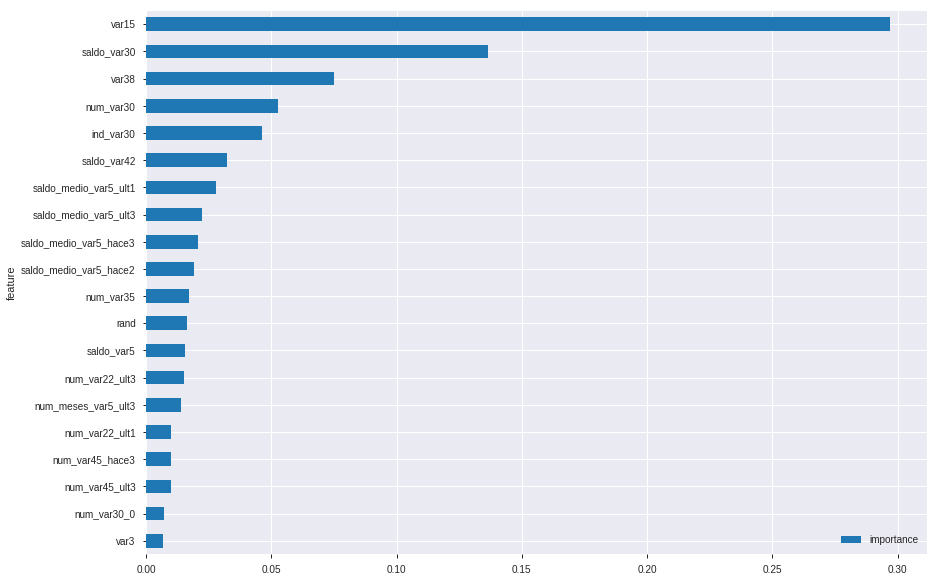

In [106]:
_ = pd.DataFrame(zip(X_train.columns, rf_rand.feature_importances_), 
                 columns=['feature','importance']).\
                 set_index('feature').\
                 sort_values(by='importance').\
                 iloc[-20:].plot.barh(figsize=(14,10))

Com apenas 11 variáveis, usando este método de feature selection, quase que replicamos a performance do melhor modelo, treinado com 161 variáveis. Os resultados seguem!

In [107]:
ft_imp = pd.DataFrame(zip(X_train.columns, rf_rand.feature_importances_), 
                 columns=['feature','importance']).\
                 set_index('feature')

rand_imp = ft_imp.loc['rand'][0]

better_than_random = ft_imp.sort_values(by='importance', ascending=False).query("importance>@rand_imp").index

In [108]:
params = bst_max_profit_model.get_params()
params['max_features'] = 'auto'

In [109]:
X_train, X_test, y_train, y_test = train_test_split(df[all_vars], df[target], test_size=0.2, random_state=25)

X_train = X_train[better_than_random]
X_test = X_test[better_than_random]

rf_better_than_rand = RandomForestClassifier(**params)
rf_better_than_rand.fit(X_train, y_train)

show_performance(rf_better_than_rand, X_test, y_test)

Matriz de confusão:
[[12953  1637]
 [  287   327]]

Lucro obtido com a ação (em Reais): R$ 13060
Porcentagem do lucro ideal: 23.63%


In [110]:
param_grid = {'max_depth':[16],
              'n_estimators':[50],
              'class_weight':[{0:1,1:11},{0:1,1:12}], #tentativa de contornar o desbalanceamento do dataset
              'min_samples_split':[int(X_train.shape[0]*0.005),int(X_train.shape[0]*0.0049)],
              'max_features':['auto']
             }

gsearch = GridSearchCV(rf, param_grid=param_grid, scoring=max_profit_scorer, cv=3, n_jobs=-1, verbose=8)
gsearch.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   17.0s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   24.3s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   25.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'class_we

In [111]:
show_performance(gsearch.best_estimator_, X_test, y_test)

Matriz de confusão:
[[12950  1640]
 [  281   333]]

Lucro obtido com a ação (em Reais): R$ 13570
Porcentagem do lucro ideal: 24.56%


Parece que estamos chegando no limite do possível usando a abordagem de tunagem de hiperparâmetros e descarte simples de variáveis, algo em torno de 25% do máximo lucro no conjunto teste. Ainda poderíamos utilizar algum filtro para remover variáveis correlacionadas.

Uma nova abordagem seria utilizar outro algorítimo de modelagem (GBTs usando as bibliotecas XGboost ou a Lightgbm). Outra opção é tentar balancear o dataset artificialmente, usando "undersampling" ou "oversampling". Tentaremos as duas. Abaixo definimos uma função simples para fazer a subamostragem num dataset com target binário:

In [112]:
def undersample(df):

    # Shuffle the Dataset.
    shuffled_df = dftrain.sample(frac=1,random_state=4)

    # Put all the positive class in a separate dataset.
    positive_df = shuffled_df.loc[shuffled_df[target] == 1]

    #Randomly select the observations from the majority class
    negative_df = shuffled_df.loc[shuffled_df[target] == 0].sample(n=positive_df.shape[0],random_state=42)

    # Concatenate both dataframes again
    balanced_df = pd.concat([positive_df, negative_df])
    
    return balanced_df

Antes de fazer a subamostragem, separamos um conjunto teste com as mesmas frequências na target do dataset original. Isso é importante para podermos avaliar como um modelo treinado num dataset balanceado artificialmente performaria num cenário "real".

In [113]:
#Aqui separamos um conjunto de validação com a frequência real com a target apareceria
#com o intuito de testar o modelo treinado num dataset com undersampling num dataset "real"
dftrain, X_test_original, targettrain, y_test_original = train_test_split(df[all_vars],
                                                                          df[target],
                                                                          test_size = 0.2,
                                                                          random_state=31)
dftrain[target] = targettrain

#Novo dataset com undersampling
balanced_df = undersample(dftrain)

Abaixo segue a performance do dataset num conjunto teste balanceado artificialmente! Parece muito promissor! Saltamos para um lucro de quase R\\$ 40.000,00, que representa um lucro de mais de 70% do ideal. Antes afirmar que este é um modelo ótimo, vamos apenas verificar como o modelo performa num dataset com as frequências que aparecem na target do dataset original.

In [114]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df[all_vars], balanced_df[target], test_size=0.2, random_state=25)

X_train = X_train[better_than_random]
X_test = X_test[better_than_random]

rf_better_than_rand = RandomForestClassifier(n_jobs=-1, random_state=42)
param_grid = {'max_depth':[14, 15, 16],
              'n_estimators':[50],
              'class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:3}], #tentativa de contornar o desbalanceamento do dataset
              'min_samples_split':[int(X_train.shape[0]*0.01), int(X_train.shape[0]*0.005)],
              'max_features':['auto']
             }


gsearch_u_samp = GridSearchCV(rf_better_than_rand, param_grid=param_grid, scoring=max_profit_scorer, cv=3, n_jobs=-1, verbose=8)
gsearch_u_samp.fit(X_train, y_train)


show_performance(gsearch_u_samp.best_estimator_, X_test, y_test)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    9.5s finished


Matriz de confusão:
[[232 241]
 [ 48 443]]

Lucro obtido com a ação (em Reais): R$ 37460
Porcentagem do lucro ideal: 84.77%


Nããooo! Estávamos tão perto! Infelizmente acabamos com um modelo que no mundo real traria um prejuízo de mais de R\\$ 20.000,00!

In [115]:
X_train = balanced_df[all_vars] 
y_train = balanced_df[target]

X_train = X_train[better_than_random]
X_test_original = X_test_original[better_than_random]

rf_better_than_rand = RandomForestClassifier(**gsearch_u_samp.best_estimator_.get_params())
rf_better_than_rand.fit(X_train, y_train)

show_performance(rf_better_than_rand, X_test_original, y_test_original )

Matriz de confusão:
[[7769 6836]
 [  64  535]]

Lucro obtido com a ação (em Reais): R$ -20210
Porcentagem do lucro ideal: -37.49%


Por fim, por desencargo de consciência, tentaremos o oversampling usando a técnica SMOTE, a mais popular, usando uma biblioteca já pronta. O procedimento é o mesmo de quando utilizamos o random undersampling anteriormente. Separamos um conjunto teste no início com as frequências da target original e treinamos. Segue o lucro. É pequeno, porém é um lucro e não prejuízo!

In [55]:
#Aqui separamos um conjunto de validação com a frequência real com a target apareceria
#com o intuito de testar o modelo treinado num dataset com undersampling num dataset "real"
X, X_test_original, y, y_test_original = train_test_split(df[all_vars],
                                                                          df[target],
                                                                          test_size = 0.2,
                                                                          random_state=33)

X_train, y_train = SMOTE().fit_resample(X, y)

X_train = pd.DataFrame(X_train, columns=all_vars)
y_train = pd.DataFrame(y_train, columns=[target])

X_train = X_train[better_than_random]
X_test_original = X_test_original[better_than_random]

rf_better_than_rand = RandomForestClassifier(**bst_max_profit_model.get_params())
rf_better_than_rand.fit(X_train, y_train)

show_performance(rf_better_than_rand, X_test_original, y_test_original)

Matriz de confusão:
[[10784  3821]
 [  158   441]]

Lucro obtido com a ação (em Reais): R$ 1480


Abaixo segue mais um modelo com o dataset sobreamostrado tunado com outros hiperparâmetros. O resultado abaixo é muito melhor, quase replicando a performance do nosso melhor modelo (talvez tunando ainda mais os hiperparametros seja possível replicar a performance do dataset desbalanceado). A desvantagem? o Dataset é muito maior e por isso demora muito mais para treinar.

In [ ]:
param_grid = {'max_depth':[14, 15, 16],
              'n_estimators':[50],
              'class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:3}], #tentativa de contornar o desbalanceamento do dataset
              'min_samples_split':[int(X_train.shape[0]*0.01), int(X_train.shape[0]*0.005)],
              'max_features':['auto',40]
             }


gsearch_o_samp = GridSearchCV(rf, param_grid=param_grid, scoring=max_profit_scorer, cv=3, n_jobs=-1, verbose=8)
gsearch_o_samp.fit(X_train, y_train)

In [57]:
show_performance(gsearch_o_samp.best_estimator_, X_test_original, y_test_original)

Matriz de confusão:
[[12481  2124]
 [  246   353]]

Lucro obtido com a ação (em Reais): R$ 10530


Backlog de coisas para testar:

* Descritiva mais aprofundada e possível uso de encodings em possíveis variáveis catégoricas que estão como inteiras (uso de target encoding por exemplo);
* Feature engineering (manual ou automático com bibliotecas como feature tools);
* Melhores métodos de feature selection;
* Usar a biblioteca SHAP para tirar importância das variáveis (inclusive no método de feature selection que utilizamos)
* Treinar modelo com GBTs usando bibliotecas XGboost e LightGBM;
* Busca mais inteligente e extensiva no espaço de hiperparâmetros - tanto para o dataset desbalanceado original quanto para os balanceados artificialmente (melhor GridSearch ou uso de buscas com heurística como algorítimo genético);
* Usar TPOT;

<center> <font size=5> <b> Questão B </b> </font> </center>

Para escorar o público da base teste com notas de 1 a 5, usaremos a ordenação do modelo Random Forest que pode ser obtida através através das probabilidades, outputs do modelo (disponível usando o método predict_proba), ou seja, quanto maior a probabilidade maior a chance do indivíduo estar insatisfeito, dada a target.

In [116]:
X_train, X_test, y_train, y_test = train_test_split(df[all_vars], df[target], test_size=0.2, random_state=25)

y_pred_train = gsearch.best_estimator_.predict(X_train[better_than_random])
y_pred_proba_train = gsearch.best_estimator_.predict_proba(X_train[better_than_random])[:,1]
y_pred = gsearch.best_estimator_.predict(X_test[better_than_random])
y_pred_proba = gsearch.best_estimator_.predict_proba(X_test[better_than_random])[:,1]

In [117]:
pr, recall, thr = precision_recall_curve(y_test, y_pred_proba)
pr_train, recall_train, thr_train = precision_recall_curve(y_train, y_pred_proba_train)

Abaixo segue a análise da precisão e sensibilidade vs o limiar de probabilidade (estudo feito com o conjunto de treinamento).

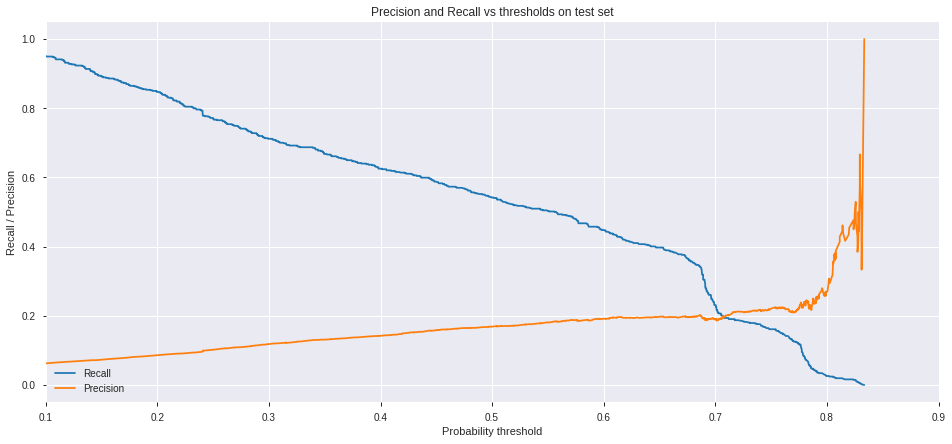

In [119]:
_ = plt.figure(figsize=(16,7))
_ = plt.plot(thr, recall[1:],label='Recall')
_ = plt.plot(thr, pr[1:],label='Precision')
_ = plt.xlabel('Probability threshold')
_ = plt.ylabel('Recall / Precision')
_ = plt.title('Precision and Recall vs thresholds on test set')
_ = plt.legend()
_ = plt.xlim([0.1,0.9])
plt.show()

A seguir seguem os gráficos do máxima porcentagem de lucro possível pelo limiar de probabilidade tanto no conjunto de treinamento e no conjunto de teste. Algum overfitting fica evidente ao avaliar os gráficos abaixo.

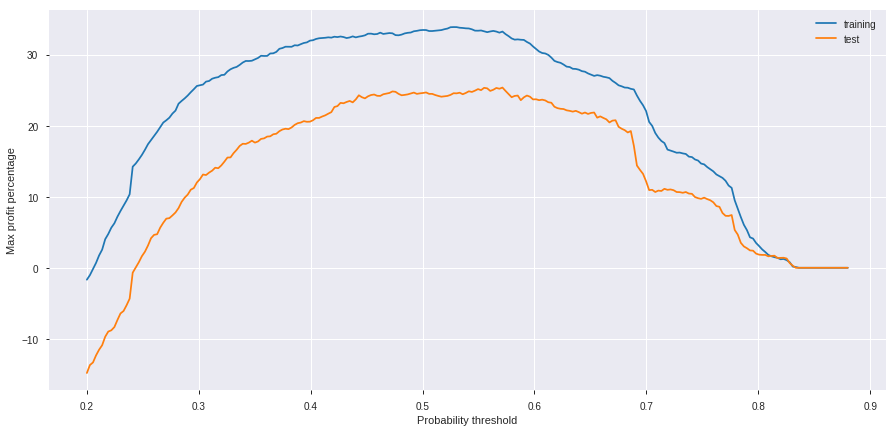

In [120]:
thresholds = np.linspace(0.2,0.88,250)
total_profit_percentage = [max_profit_score(y_train, (y_pred_proba_train > i)*1)/(y_train.sum()*90)*100 for i in thresholds]
total_profit_percentage_test = [max_profit_score(y_test, (y_pred_proba > i)*1)/(y_test.sum()*90)*100 for i in thresholds]
_ = plt.figure(figsize=(15,7))
_ = plt.plot(thresholds, total_profit_percentage, label='training')
_ = plt.plot(thresholds, total_profit_percentage_test, label='test')
_ = plt.ylabel('Max profit percentage')
_ = plt.xlabel('Probability threshold')
_ = plt.legend()

In [121]:
threshold_for_max_profit = thresholds[np.argmax(total_profit_percentage)]
print(threshold_for_max_profit)

0.5277108433734939


In [122]:
print(classification_report(y_test, (y_pred_proba > threshold_for_max_profit)*1) )

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     14590
           1       0.17      0.52      0.26       614

    accuracy                           0.88     15204
   macro avg       0.58      0.71      0.60     15204
weighted avg       0.95      0.88      0.91     15204



In [123]:
notas = pd.cut(y_pred_proba, bins=list(np.linspace(0,threshold_for_max_profit,5))+[1.0], labels=[5,4,3,2,1])

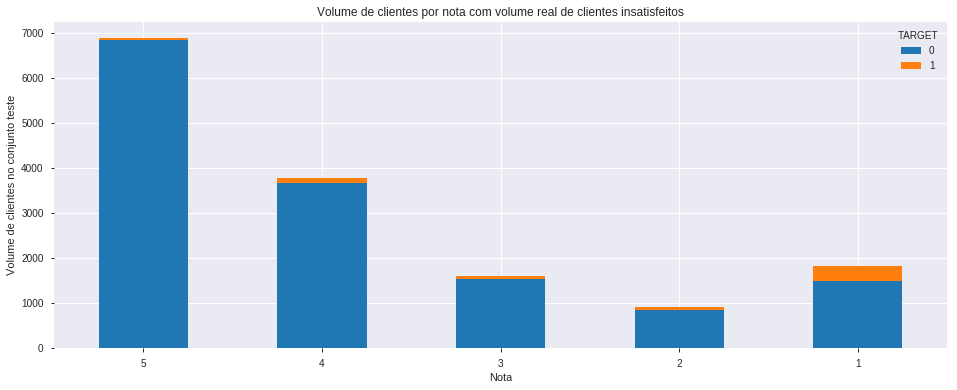

In [124]:
_ = pd.concat((pd.Series(notas, name='notas'), y_test.reset_index(drop=True)), axis=1, ignore_index=False).\
    groupby([target,'notas']).size().unstack(target).plot.bar(stacked=True,figsize = (16,6))
_ = plt.xticks(rotation=0)
_ = plt.ylabel('Volume de clientes no conjunto teste')
_ = plt.xlabel('Nota')
_ = plt.title('Volume de clientes por nota com volume real de clientes insatisfeitos')

In [125]:
print("Lucro total das notas 1 no conjunto de treinamento: R$ "+str(max_profit_score(y_test, (notas == 1)*1)))
print("Representando "+str(round(max_profit_score(y_test, (notas == 1)*1)/(y_test.sum()*90)*100,1))+ "% do máximo lucro possível no conjunto de teste.")

Lucro total das notas 1 no conjunto de treinamento: R$ 13570
Representando 24.6% do máximo lucro possível no conjunto de teste.


Backlog de coisas para testar:

* Escolha mais inteligente das faixas das notas 2-5 de modo a garantir precisão cada vez maior quanto menor a nota;
* Melhora na questão A reflete melhor resposta na B;

<center> <font size=5> <b> Questão C </b> </font> </center>

O primeiro passo para fazer um aprendizado supervisionado foi definir um pipeline de feature selection que não dependesse da target e que ainda assim fosse robusto. Para isso definimos a função a seguir que dropa encontra grupos de variáveis correlacionadas mantendo apenas uma das features de cada grupo (escolha aleatória).

In [126]:
def get_uncorrelated_features(X_train):

    corrmat = X_train.corr()
    corrmat = corrmat.abs().unstack() # absolute value of corr coef
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = pd.DataFrame(corrmat).reset_index(level=0)
    corrmat.columns = ['feature2','corr']
    corrmat = pd.DataFrame(corrmat).reset_index().rename(columns={'index':'feature1'})
    corrmat = corrmat.query('(corr<1) & (corr>=0.8)')

    # find groups of correlated features
    grouped_feature_ls = []
    correlated_groups = []

    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:

            # find all features correlated to a single feature
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]

            # append the block of features to the list
            correlated_groups.append(correlated_block)

    print('found {} correlated groups'.format(len(correlated_groups)))
    print('out of {} total features'.format(X_train.shape[1]))
    
    def get_all_group_features(df):
        return df.feature2.to_list()+list(df.feature1.unique())

    def get_random_feature(features):
        return np.random.choice(get_all_group_features(group))
    
    uncorrelated_features = list(set(X_train.columns)-set(grouped_feature_ls))
    for group in correlated_groups:
        uncorrelated_features.append(get_random_feature(get_all_group_features(group)))
        
    return uncorrelated_features

A seguir seguimos o seguinte pipeline. Separamos nosso dataset em conjunto de treino e teste como nos passos anteriores usando um novo seed. Removemos as variáveis constantes e as quase constantes (método de feature selection que não depende da target). A seguir determinamos os grupos de variáveis correlacionadas mantendo apenas uma variável de cada grupo. Por fim, standardizamos cada uma das features e usamos um PCA escolhendo 11 componentes (escolha baseada na análise dos outputs).

In [212]:
X_train, X_test, y_train, y_test = train_test_split(df[all_vars], df[target], test_size=0.2, random_state=19)

X_train = X_train[non_constant_vars]
X_test = X_test[non_constant_vars]

uncorrelated_features = get_uncorrelated_features(X_train)

print(len(uncorrelated_features))

X_train = X_train[uncorrelated_features]
X_test = X_test[uncorrelated_features]

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=uncorrelated_features)
X_test = pd.DataFrame(scaler.transform(X_test), columns=uncorrelated_features)

n_comp=15
pca = PCA(n_components=n_comp)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(sum(pca.explained_variance_ratio_))

found 35 correlated groups
out of 161 total features
68
0.6338188716264601


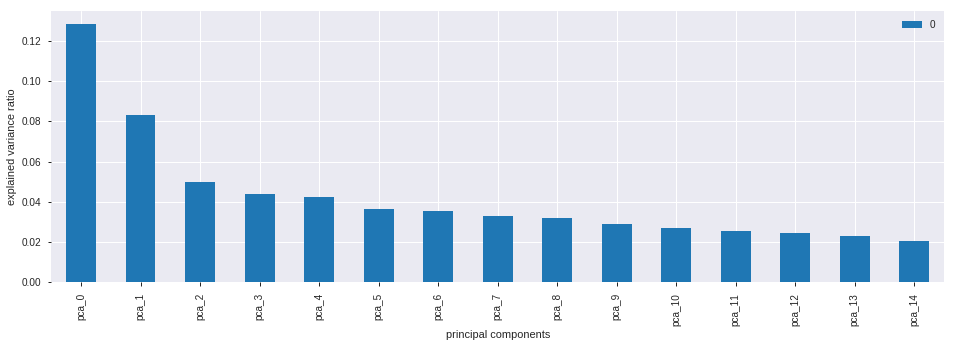

In [250]:
pca_components = ['pca_{}'.format(str(i)) for i in range(n_comp)]
_ = pd.DataFrame(pca.explained_variance_ratio_, index=pca_components).plot.bar(figsize=(16,5))
_ = plt.ylabel('explained variance ratio')
_ = plt.xlabel('principal components')

Aqui verificamos se ainda conseguirmos obter uma boa performance de lucro com esse conjunto reduzido de variáveis (sim, apesar do lucro ser menor, não é significativamente menor! mas o número de variáveis é bem mais baixo! Da mesma ordem do método de feature selection que usa a variável aleatória e a target. Conseguimos reduzir significativamente a dimensionalidade do dataset sem usar a target.

In [213]:
rf_pca= RandomForestClassifier(**params)
rf_pca.fit(X_train, y_train)

show_performance(rf_pca, X_test, y_test)

Matriz de confusão:
[[13256  1338]
 [  327   283]]

Lucro obtido com a ação (em Reais): R$ 12090
Porcentagem do lucro ideal: 22.02%


Pair plot das primeiras 5 componentes principais. Fiz o plot para investigar se havia clusteres óbvios surgindo dos dados, o que não é caso. Tudo parece estar num único grande cluster globular, não há grandes grupos linearmente separáveis. Talvez isso seja um efeito da rotação do espaço que busca os eixos com maior variância (sendo que possívelmente não há nenhuma separação nesses eixos de maior variância).

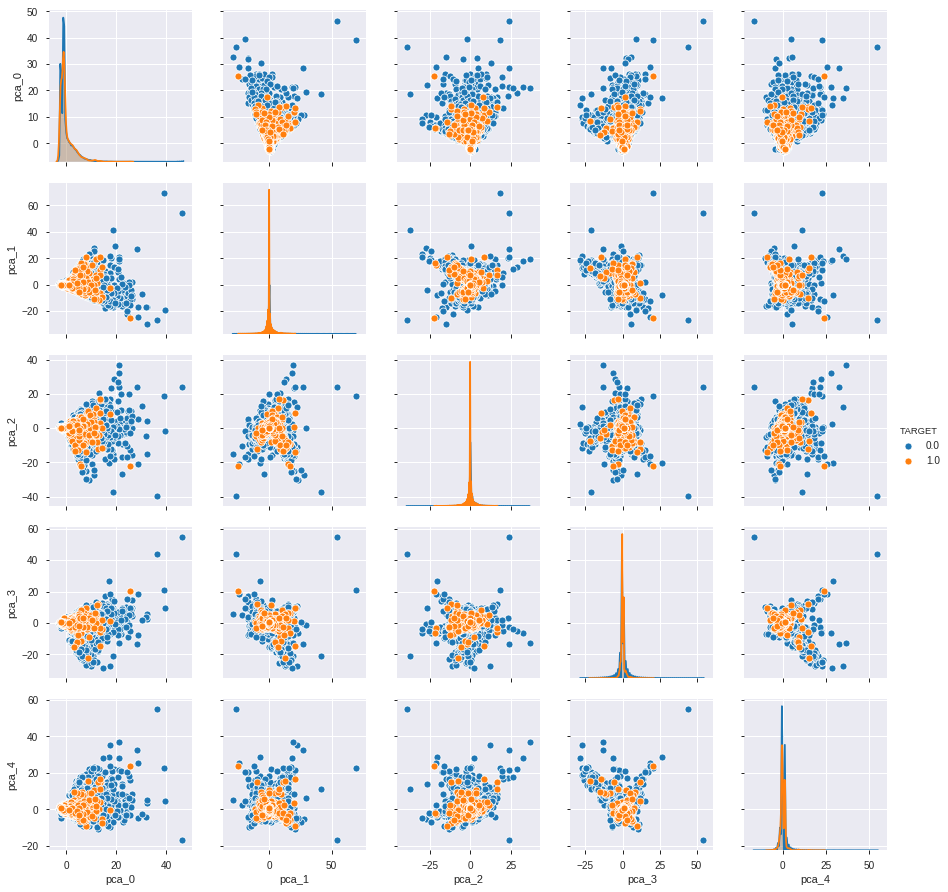

In [214]:
X_train = pd.DataFrame(X_train,columns = pca_components)
X_train[target] = y_train
_ = sns.pairplot(X_train, x_vars=pca_components[:5], y_vars=pca_components[:5],  hue=target)

Abaixo utilizamos 

In [215]:
max_n_clusters = 30
min_n_clusters = 3
clusterings = [KMeans(n_clusters=i,n_init=500,random_state=42, n_jobs=-1).fit(X_train[pca_components]) 
               for i in range(min_n_clusters,max_n_clusters+1)]
inertias = [model.inertia_ for model in clusterings]

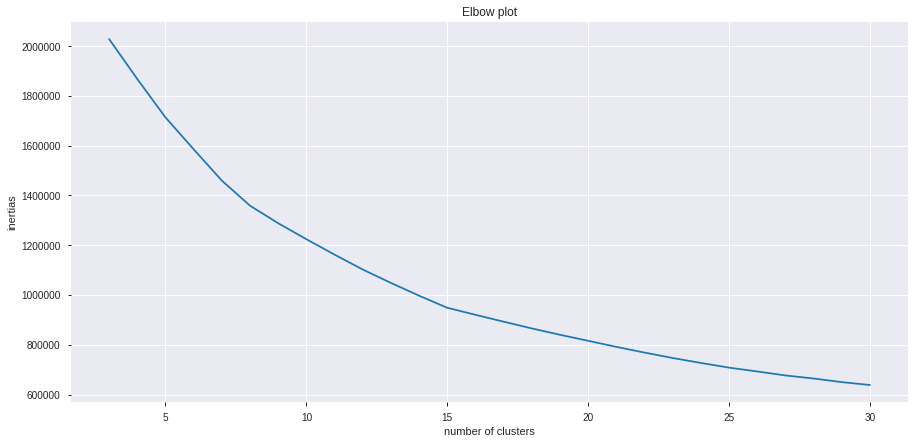

In [216]:
_ = plt.figure(figsize=(15,7))
_ = sns.lineplot(range(min_n_clusters ,max_n_clusters+1), inertias)
_ = plt.ylabel('inertias')
_ = plt.xlabel('number of clusters')
_ = plt.title('Elbow plot')

In [217]:
silhouttes = [silhouette_score(X_train[pca_components],model.labels_,sample_size=5000) for model in clusterings]

Pelo gráfico a seguir o número de clusteres deveria ser 3, aliás provavelmente seria menos se tivéssemos colocado isso no range dos n_clusters. No entanto, forçamos uma escolha maior que 3 e o próximo maior score de silhouta é de 21 clusteres. De fato a diferença entre os escores de silhouta para n_clusteres 3 e 21 é pequena (é menos de 4% da magnitude do score de silhouta n_clusteres 3), por isso consideramos uma escolha razoável.

In [263]:
print(round((silhouttes[0]-silhouttes[np.argmax(silhouttes[1:])+1])/silhouttes[0]*100,2))

3.97


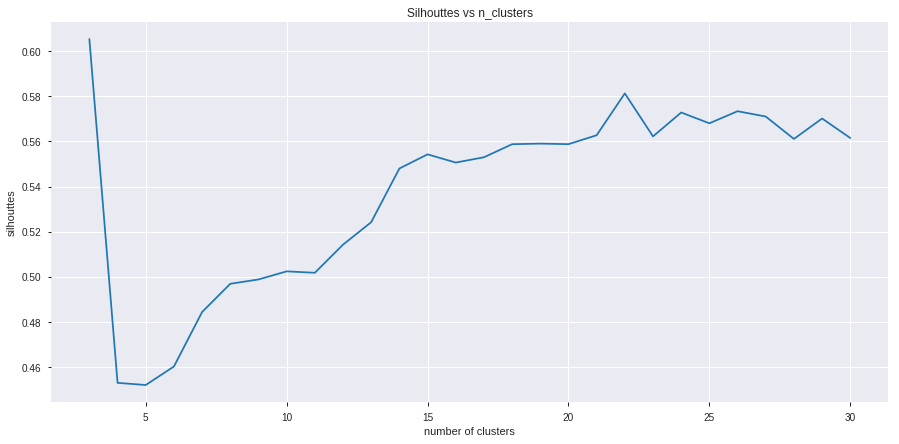

In [221]:
_ = plt.figure(figsize=(15,7))
_ = plt.plot(range(min_n_clusters,max_n_clusters+1), silhouttes)
_ = plt.ylabel('silhouttes')
_ = plt.xlabel('number of clusters')
_ = plt.title('Silhouttes vs n_clusters')

A seguir seguem os clusteres ordenados em ordem decrescentes de lucratividade (percentual de máximo lucro possível). Note que apenas o primeiro cluster dá algum lucro - porém sua volumetria é muito baixa e suspeitamos que seja apenas ruído. De fato quando olhamos a seguir a lucratividade no conjunto de treinamento usado para formar os clusteres, o cluster 21 perde várias posições.  A ordem dos 4 clusteres seguintes é a mesma nos dois conjuntos (três deles tem volumetria maior que 250 observações no conjunto teste). Assim escolheria a princípio estes três clusteres como sendo os mais lucrativos!

In [255]:
best_kmeans = np.argmax(silhouttes[1:])+1

labels = clusterings[best_kmeans].predict(X_test)

df_cluster_validation = pd.DataFrame({'labels': labels, 'true_target': y_test})

# Create crosstab: ct
ct = pd.crosstab(df_cluster_validation['labels'],df_cluster_validation['true_target'])

ct['volumetria'] = ct[0]+ct[1]
ct['lucro'] = ct[1]*90 - ct[0]*10
ct['max_profit_percentage'] = round(ct['lucro']/(ct[1]*90)*100,2)
ct.sort_values(by='max_profit_percentage', ascending=False)

true_target,0,1,volumetria,lucro,max_profit_percentage
labels,,,,,
21,49,6,55,50,9.26
9,3660,352,4012,-4920,-15.53
15,255,17,272,-1020,-66.67
8,61,4,65,-250,-69.44
1,463,28,491,-2110,-83.73
6,1267,52,1319,-7990,-170.73
4,611,24,635,-3950,-182.87
16,112,3,115,-850,-314.81
19,40,1,41,-310,-344.44


Mesma coisa que tabela acima, mas para o conjunto de treinamento:

In [256]:
labels = clusterings[best_kmeans].labels_

df_cluster_validation = pd.DataFrame({'labels': labels, 'true_target': y_train})

# Create crosstab: ct
ct = pd.crosstab(df_cluster_validation['labels'],df_cluster_validation['true_target'])

ct['volumetria'] = ct[0]+ct[1]
ct['lucro'] = ct[1]*90 - ct[0]*10
ct['max_profit_percentage'] = round(ct['lucro']/(ct[1]*90)*100,2)
ct.sort_values(by='max_profit_percentage', ascending=False)

true_target,0,1,volumetria,lucro,max_profit_percentage
labels,,,,,
9,14429,1408,15837,-17570,-13.87
15,1016,87,1103,-2330,-29.76
8,164,12,176,-560,-51.85
1,1674,81,1755,-9450,-129.63
16,473,19,492,-3020,-176.61
21,221,8,229,-1490,-206.94
6,5098,181,5279,-34690,-212.95
4,2343,81,2424,-16140,-221.40
19,181,4,185,-1450,-402.78


Segue algumas tentativas de realizar clusterização hierárquica aglomerativa - single linkage:

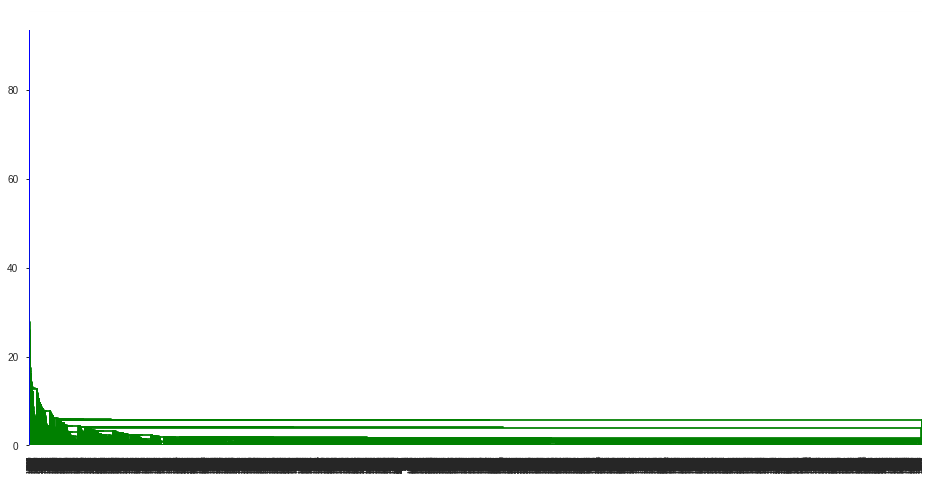

In [141]:
X_train_sample = X_train.sample(frac=0.2)[pca_components]

# Calculate the linkage: mergings
mergings = linkage(X_train_sample, method='single')

# Plot the dendrogram, using varieties as labels
plt.figure(figsize=(16,8))
dendrogram(mergings, leaf_rotation=90, leaf_font_size=6)
plt.show()

Aqui segue a tentativa de realizar clusterização hierárquica aglomerativa - complete linkage -  o resultado é bem diferente da clusterização acima. É possível escolher um número de clusteres maior que 1.

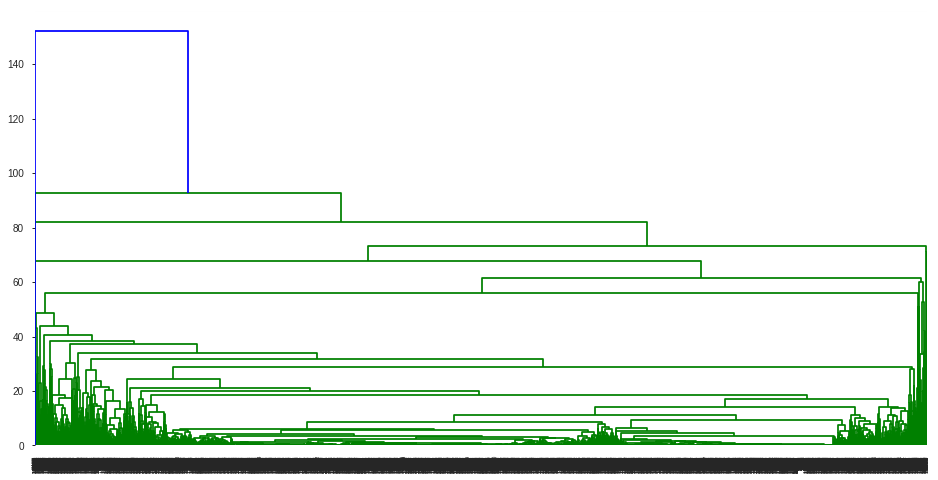

In [142]:
# Calculate the linkage: mergings
mergings = linkage(X_train_sample, method='complete')

# Plot the dendrogram, using varieties as labels
plt.figure(figsize=(16,8))
dendrogram(mergings, leaf_rotation=90, leaf_font_size=6)
plt.show()

Backlog de coisas para testar:

* Mais feature engineering antes de começar a clusterização;
* Usar o KMeans com mais inicializações (com poucas havia variação nos gráficos de silhueta e elbow quando mudávamos o seed) - deveríamos inicializar mais a depender do número de clusteres escolhidos - algo que notei só agora (que burro! dá zero pra ele - não, não dá não!);
* Métodos soft (que atribuem uma probabilidade da observação pertencer a um cluster);
* GMM - que considerariam clusteres que não tem formator globular, mas elipsoidais;
* Não fazer PCA ou entender melhor as combinações dos componentes e tentar explicar os clusteres através das variáveis originais;
* Clusterização usando redes - percolação;